#### <center> Defaulters predictions using ANFIS algorithm <center> 

#### Importing libraries

In [2]:
### Loading libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, roc_auc_score, auc, roc_curve, precision_recall_curve,log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow.compat.v1 as tf
import time
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from tensorflow import keras 

#### ANFIS function

In [3]:
#  ANFIS code
class ANFIS:

    def __init__(self, n_inputs, n_rules, learning_rate=1e-2):
        self.n = n_inputs
        self.m = n_rules
        self.inputs = tf.placeholder(tf.float32, shape=(None, n_inputs))  # Input
        self.targets = tf.placeholder(tf.float32, shape=None)  # Desired output
        
        print("desired output:", self.targets)
        mu = tf.get_variable("mu", [n_rules * n_inputs],
                             initializer=tf.random_normal_initializer(0, 1))  # Means of Gaussian MFS
        print('mean', mu)
        sigma = tf.get_variable("sigma", [n_rules * n_inputs],
                                initializer=tf.random_normal_initializer(0, 1))  # Standard deviations of Gaussian MFS
        print('sigma',sigma)
        y = tf.get_variable("y", [1, n_rules], initializer=tf.random_normal_initializer(0, 1))  # Sequent centers
        
        print('sequent centers', y)

        self.params = tf.trainable_variables()

        self.rul = tf.reduce_prod(
            tf.reshape(tf.exp(-0.5 * tf.square(tf.subtract(tf.tile(self.inputs, (1, n_rules)), mu)) / tf.square(sigma)),
                       (-1, n_rules, n_inputs)), axis=2)  # Rule activations
        
        print("rules",self.rul)
        # Fuzzy base expansion function:
        num = tf.reduce_sum(tf.multiply(self.rul, y), axis=1)
        print("num", num)
        den = tf.clip_by_value(tf.reduce_sum(self.rul, axis=1), 1e-12, 1e12)
        print("den", den)
        self.out = tf.divide(num, den)
        print("out", self.out)

        self.loss = tf.losses.huber_loss(self.targets, self.out)  # Loss function computation
        self.optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)  # Optimization step
        self.init_variables = tf.global_variables_initializer()  # Variable initializer

    def infer(self, sess, x, targets=None):
        if targets is None:
            return sess.run(self.out, feed_dict={self.inputs: x})
        else:
            return sess.run([self.out, self.loss], feed_dict={self.inputs: x, self.targets: targets})

    def train(self, sess, x, targets):
        yp, l, _ = sess.run([self.out, self.loss, self.optimize], feed_dict={self.inputs: x, self.targets: targets})
        return l, yp

    def plotmfs(self, sess):
        mus = sess.run(self.params[0])
        mus = np.reshape(mus, (self.m, self.n))
        sigmas = sess.run(self.params[1])
        sigmas = np.reshape(sigmas, (self.m, self.n))
        y = sess.run(self.params[2])
        xn = np.linspace(-1.5, 1.5, 1000)
        for r in range(self.m):
            if r % 4 == 0:
                plt.figure(figsize=(11, 6), dpi=80)
            plt.subplot(2, 2, (r % 4) + 1)
            ax = plt.subplot(2, 2, (r % 4) + 1)
            ax.set_title("Rule %d, sequent center: %f" % ((r + 1), y[0, r]))
            for i in range(self.n):
                plt.plot(xn, np.exp(-0.5 * ((xn - mus[r, i]) ** 2) / (sigmas[r, i] ** 2)))

#### Reading the data

In [4]:
### Reading the one hot encoded data
final_data = pd.read_csv('one_hot_encoded_data.csv')

### Renaming the loan status variable as TARGET
final_data.rename(columns={'loan_status': 'TARGET'}, inplace=True)

#### Taking top 30 variables using RFE method

In [6]:
### Taking the top 30 columns data. Top 30 variables are taken using RFE with random forest.
final_data = final_data[['TARGET','loan_amount', 'funded_amount', 'funded_amount_investor', 'term',
       'interest_rate', 'debit_to_income', 'delinquency_two_years',
       'inquires_six_months', 'open_account', 'revolving_balance',
       'revolving_utilities', 'total_accounts', 'total_received_interest',
       'total_received_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_week_pay', 'total_collection_amount', 'total_current_balance',
       'total_revolving_credit_limit', 'grade_B', 'grade_C',
       'home_ownership_MORTGAGE', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'initial_list_status_f', 'loan_title_cat_Credit card refinancing',
       'loan_title_cat_Debt consolidation']]

#### Splitting the data into X and y

In [7]:
### Splitting the data in to X and y
X = final_data.loc[:, final_data.columns != 'TARGET']
y = final_data.loc[:, final_data.columns == 'TARGET']

### Checkign unique categories in y 
y['TARGET'].unique()

array([1, 0], dtype=int64)

#### Applying smote technique to balance the data

In [9]:
### Data contain imbalanced classes. Implemeting smote technique 
X_resampled, y_resampled = SMOTE().fit_resample(X, y)


#### Splitting the data  into train and test.70% train data and 30% test data

In [10]:
X_train, X_val,Y_train, Y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state = 69, stratify=y_resampled)

#X_train, X_val,Y_train, Y_val = train_test_split(X, y, test_size=0.3, random_state = 69, stratify=y)
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print("X_val",X_val.shape)
print("Y_val",Y_val.shape) 

X_train (85710, 30)
Y_train (85710, 1)
X_val (36734, 30)
Y_val (36734, 1)


#### Converting into array 

In [12]:
X_train = X_train.values
X_val = X_val.values
Y_train = Y_train.values
Y_val = Y_val.values

#### Scaling the data

In [13]:
scaler_x = StandardScaler()
#scaler_y = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_val = scaler_x.transform(X_val)
#scaler_y.fit(y_train.reshape(-1,1))
# y_train = np.round(scaler_y.transform(y_train.reshape(-1,1)))
# y_test = np.round(scaler_y.transform(y_test.reshape(-1,1)))


#### Getting counts of 0 and 1 in y train and y val

In [14]:
## get counts
unique, counts = np.unique(Y_train, return_counts=True)
print("Train:  ",dict(zip(unique, counts)))

unique, counts = np.unique(Y_val, return_counts=True)
print("Test:  ",dict(zip(unique, counts)))


Train:   {0: 42855, 1: 42855}
Test:   {0: 18367, 1: 18367}


#### Passing parameters for the ANFIS function

In [15]:
D          = X_train.shape[1]     # No of inputs
m          =   2*D   # Rules
alpha      =  0.01 # Training rate
num_epochs = 1000  # No of epochs

#### Calling ANFIS function

desired output: Tensor("Placeholder_1:0", dtype=float32)
mean <tf.Variable 'mu:0' shape=(1800,) dtype=float32>
sigma <tf.Variable 'sigma:0' shape=(1800,) dtype=float32>
sequent centers <tf.Variable 'y:0' shape=(1, 60) dtype=float32>
rules Tensor("Prod:0", shape=(None, 60), dtype=float32)
num Tensor("Sum:0", shape=(None,), dtype=float32)
den Tensor("clip_by_value:0", shape=(None,), dtype=float32)
out Tensor("truediv_1:0", shape=(None,), dtype=float32)
Train cost after epoch 0: 0.253336
Train cost after epoch 10: 0.248180
Train cost after epoch 20: 0.208489
Train cost after epoch 30: 0.137769
Train cost after epoch 40: 0.110455
Train cost after epoch 50: 0.094295
Train cost after epoch 60: 0.081837
Train cost after epoch 70: 0.070892
Train cost after epoch 80: 0.065272
Train cost after epoch 90: 0.062694
Train cost after epoch 100: 0.061065
Train cost after epoch 110: 0.059834
Train cost after epoch 120: 0.058917
Train cost after epoch 130: 0.058281
Train cost after epoch 140: 0.057753
T

<ipython-input-3-4a18e2f19a62>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2, 2, (r % 4) + 1)
<ipython-input-3-4a18e2f19a62>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2, 2, (r % 4) + 1)
<ipython-input-3-4a18e2f19a62>:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instanc

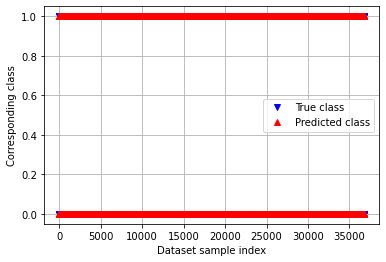

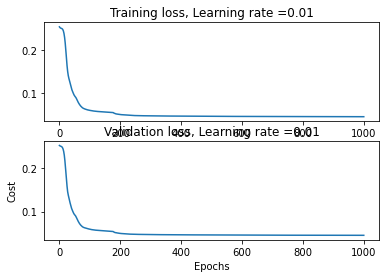

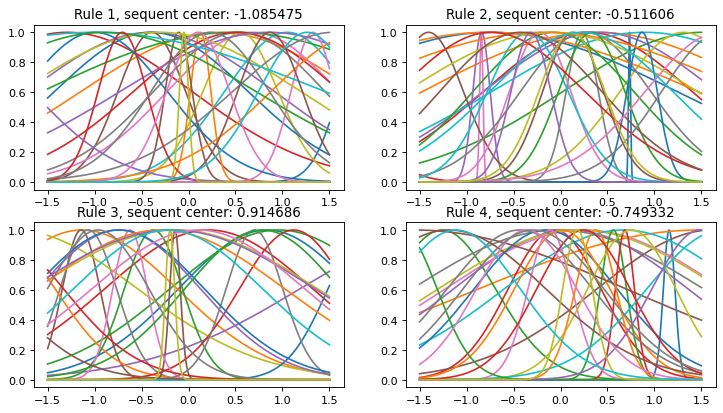

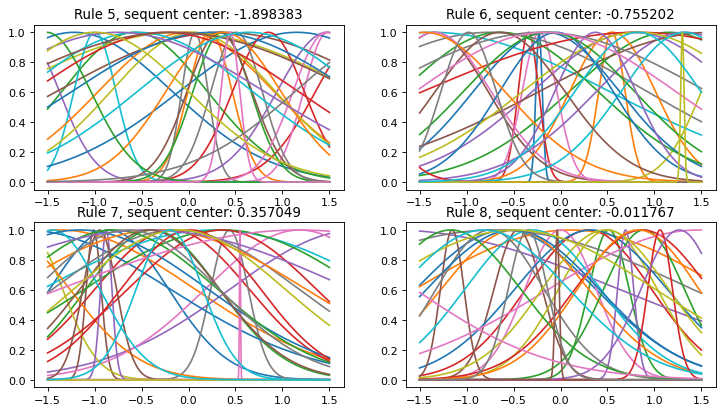

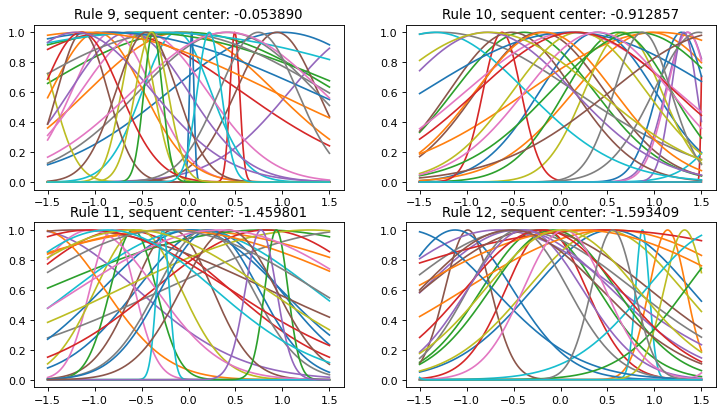

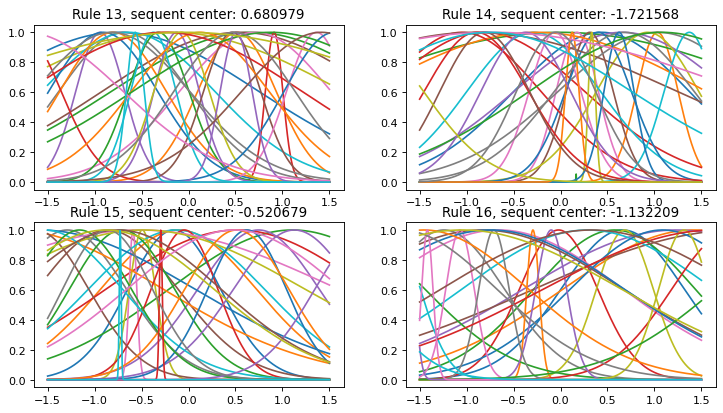

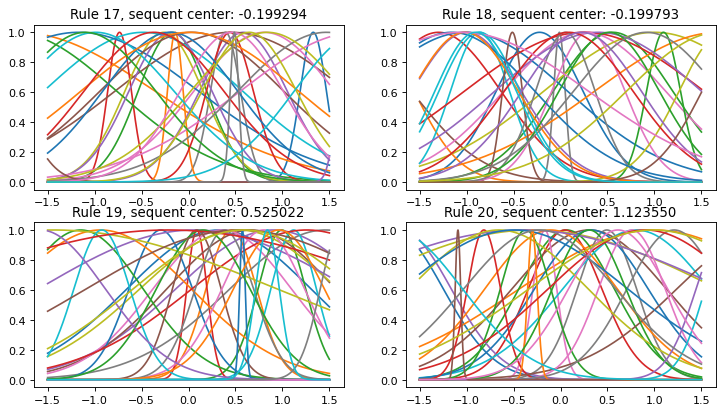

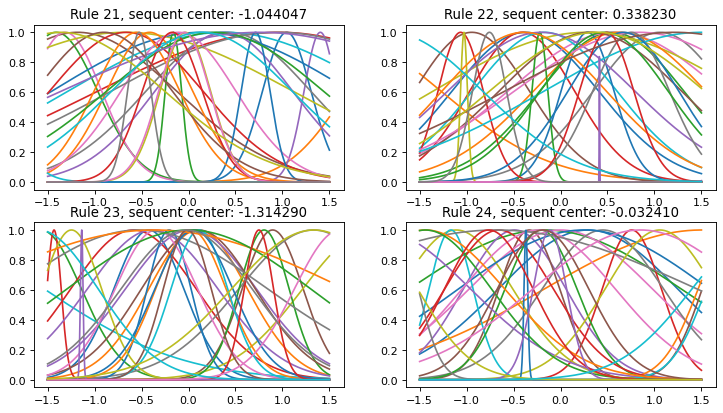

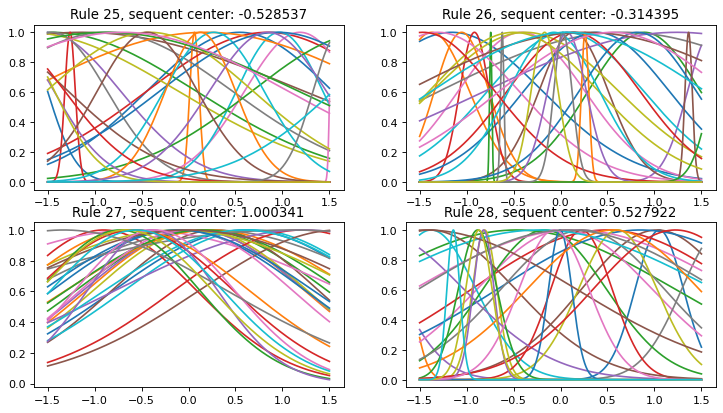

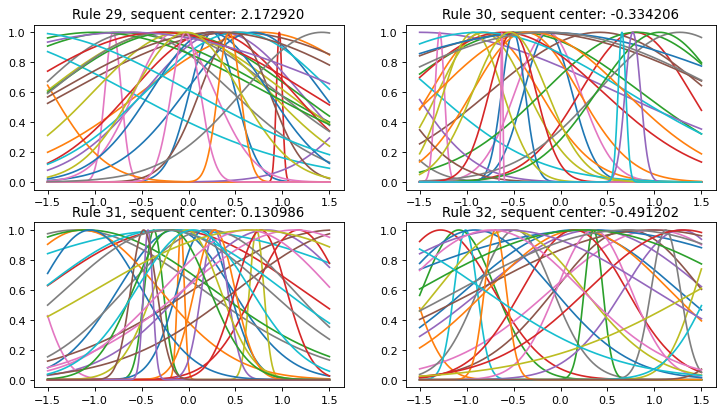

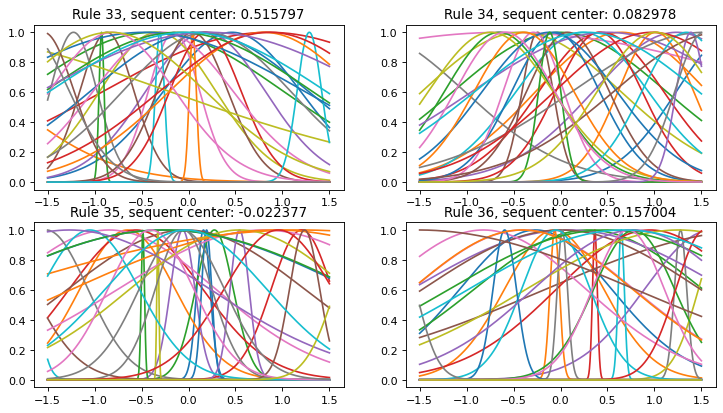

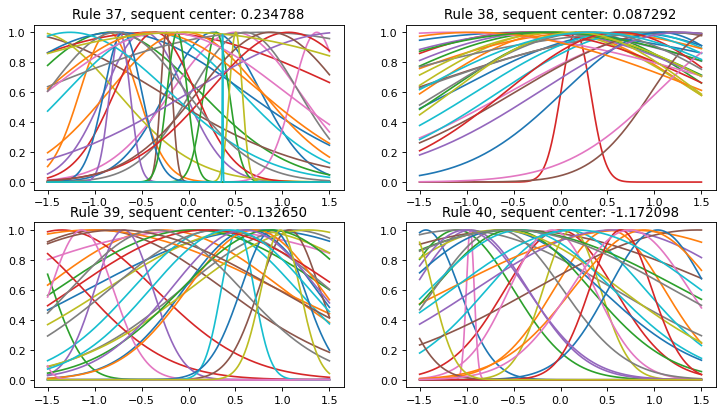

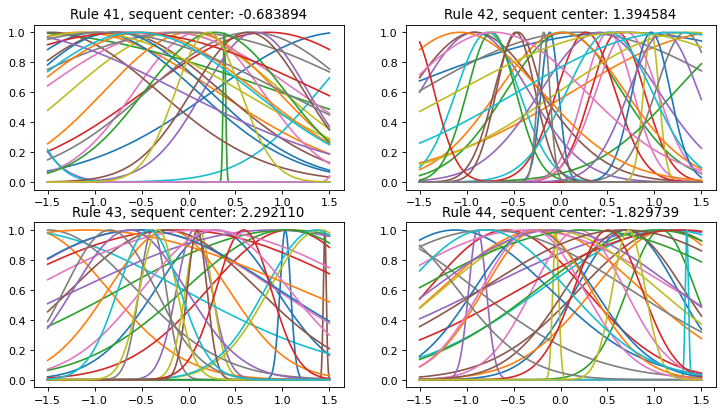

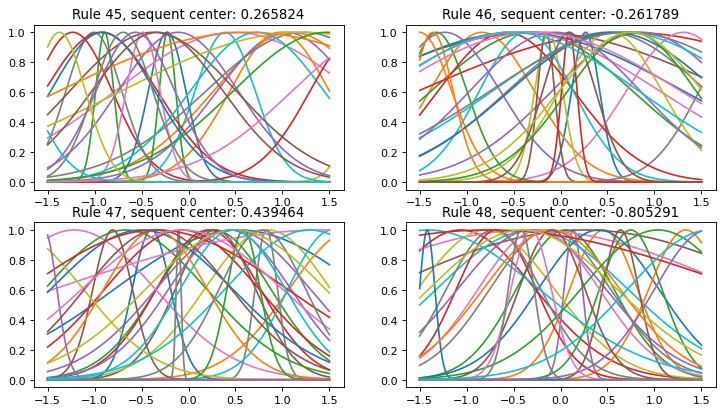

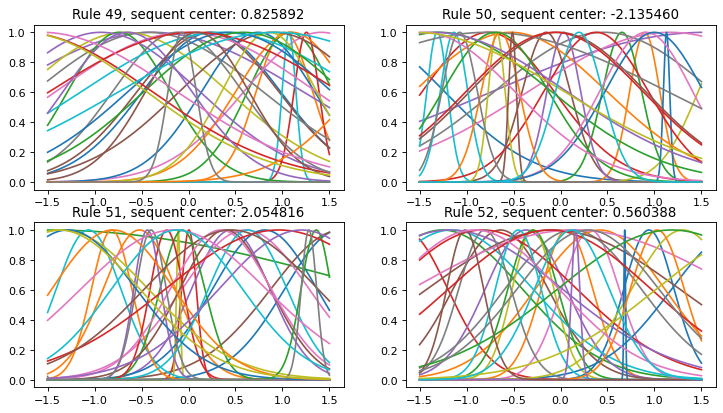

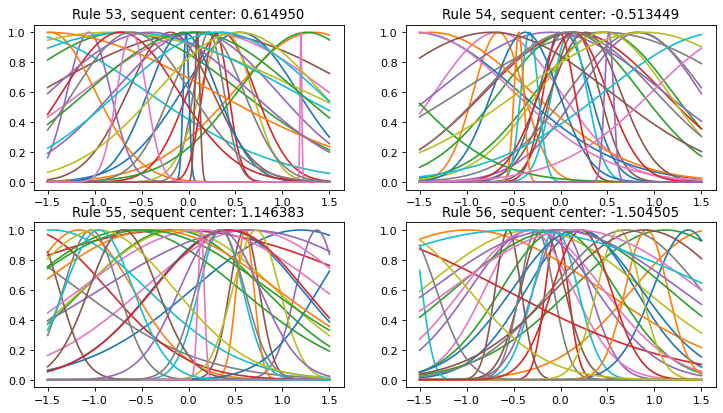

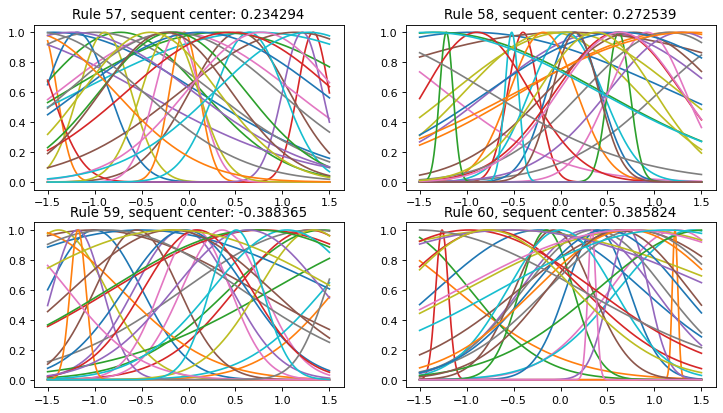

Time:  1:28:16.470192


In [16]:
# Initialize session to make computations on the Tensorflow graph
tf.compat.v1.disable_eager_execution()
fis = ANFIS(n_inputs=D, n_rules=m, learning_rate=alpha)
from datetime import datetime
start = datetime.now()
with tf.Session() as sess:
    # Initialize model parameters
    sess.run(fis.init_variables)
    trn_costs = []
    val_costs = []
    time_start = time.time()
    for epoch in range(num_epochs):
        #  Run an update step
        trn_loss, trn_pred = fis.train(sess, X_train, Y_train[:,0])
        #trn_loss = trn_loss.astype(int)
       # print("train pred: ", trn_pred)
        # Evaluate on validation set
        val_pred, val_loss = fis.infer(sess, X_val, Y_val[:,0])
        #val_loss = val_loss.astype(int)
        #print("val pred: ", val_pred)


        if epoch % 10 == 0:
            print("Train cost after epoch %i: %f" % (epoch, trn_loss))
        if epoch == num_epochs - 1:
            time_end = time.time()
            print("Elapsed time: %f" % (time_end - time_start))
            print("Validation loss: %f" % val_loss)
            # Plot real vs. predicted
            pred = np.vstack((np.expand_dims(val_pred, 1)))
            pred = np.round(pred)
        trn_costs.append(trn_loss)
        val_costs.append(val_loss)

    plt.figure(1)
    plt.plot(Y_val[:,0],'bv',label="True class")
    plt.plot(pred,'r^',label="Predicted class")
    plt.xlabel("Dataset sample index")
    plt.ylabel("Corresponding class")
    plt.legend()
    plt.grid()
    # Plot the cost over epochs
    plt.figure(2)
    plt.subplot(2, 1, 1)
    plt.plot(np.squeeze(trn_costs))
    plt.title("Training loss, Learning rate =" + str(alpha))
    plt.subplot(2, 1, 2)
    plt.plot(np.squeeze(val_costs))
    plt.title("Validation loss, Learning rate =" + str(alpha))
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    # Plot resulting membership functions
    fis.plotmfs(sess)
    plt.show()
    
end = datetime.now()
time_taken = end - start
print('Time: ',time_taken) 

#### Rounding the predictions

In [17]:
trn_pred = np.round(trn_pred,0)
#trn_pred
np.unique(trn_pred)

array([0., 1.], dtype=float32)

In [18]:
val_pred = np.round(val_pred)
#val_pred
np.unique(val_pred)

array([0., 1.], dtype=float32)

#### Accuracy score for train and test data

In [19]:
acc_tr = accuracy_score(Y_train,trn_pred)
acc_te = accuracy_score(Y_val,val_pred)
print(acc_tr)
print(acc_te)

0.878905611947264
0.881091087276093


#### Precision for train and test

In [20]:
prec_tr = precision_score(Y_train,trn_pred)
print(prec_tr)
#prec_tr=tf.keras.metrics.Precision(y_train,Y_train)
prec_te = precision_score(Y_val,val_pred)
print(prec_te)

0.931746875830896
0.9346705582810656


#### Recall for train and test

In [21]:
rec_tr = recall_score(Y_train,trn_pred)
print(rec_tr)
rec_te = recall_score(Y_val,val_pred)
print(rec_te)

0.8177108855442772
0.8194588119997822


#### F- score for train and test

In [22]:
f1_tr = f1_score(Y_train,trn_pred)
print(f1_tr)
f1_te = f1_score(Y_val,val_pred)
print(f1_te)

0.8710122413471696
0.8732811140121844


#### ROC-AUC for train and test

In [23]:
roc_auc_tr = roc_auc_score(Y_train,trn_pred)
print(roc_auc_tr)
roc_auc_te = roc_auc_score(Y_val,val_pred)
print(roc_auc_te)

0.878905611947264
0.8810910872760929


#### Confusion matrix for train and test

<Figure size 432x288 with 0 Axes>

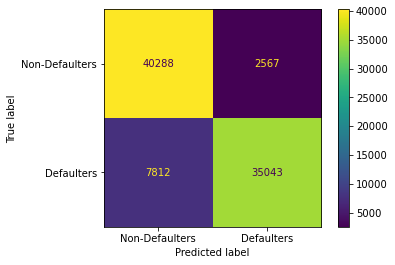

<Figure size 432x288 with 0 Axes>

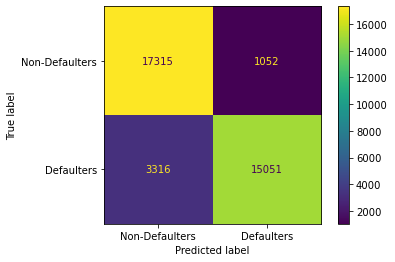

In [24]:
cm_train = confusion_matrix(Y_train,trn_pred)
cm_test = confusion_matrix(Y_val,val_pred)

plt.figure()
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,display_labels=["Non-Defaulters","Defaulters"])
disp_train = disp_train.plot(values_format='')
plt.show()

plt.figure()
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=["Non-Defaulters","Defaulters"])
disp_test = disp_test.plot(values_format='')
plt.show()


#### ROC - AUC plot function

In [25]:
# ROC Curve: Area Under the Curve
def auc_roc_plot(y_test, y_preds):
    fpr, tpr, thresholds = roc_curve(y_test,y_preds)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Plotting ROC curve for train and test

0.878905611947264


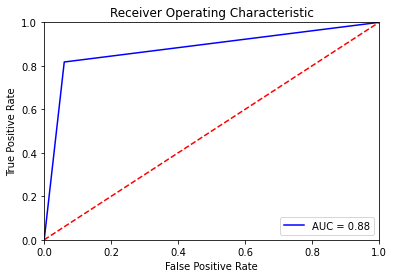

0.8810910872760929


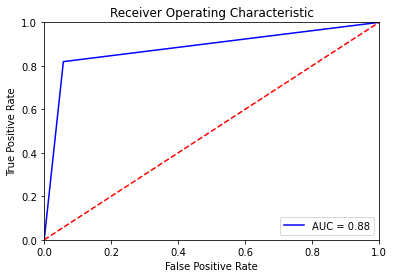

In [26]:
### Plotting roc curve
auc_roc_plot(Y_train,trn_pred)
auc_roc_plot(Y_val,val_pred)

#### Creating error metrics data frame

In [27]:
error_metrics_df = pd.DataFrame(columns=['Model name','train_count','test_count','train_accuracy',
                                             'test_accuracy','train_precision','test_precision',
                                             'train_recall','test_recall','train_Fscore','test_Fscore',
                                          'roc_auc_train','roc_auc_test'])
model_name = "ANFIS_30_var"

summary = pd.DataFrame([[model_name,len(X_train),len(X_val),
                             str(round(acc_tr,3)),
                             str(round(acc_te,3)),
                             str(round(prec_tr,3)),
                             str(round(prec_te,3)),
                             str(round(rec_tr,3)),
                             str(round(rec_te,3)),
                             str(round(f1_tr,3)),
                             str(round(f1_te,3)),
                             str(round(roc_auc_tr,3)),
                             str(round(roc_auc_te,3))
                             
                            ]],
                            columns=['Model name','train_count','test_count','train_accuracy',
                                     'test_accuracy','train_precision','test_precision',
                                     'train_recall','test_recall','train_Fscore','test_Fscore',
                                     'roc_auc_train','roc_auc_test'])



#### Printing error metrics dataframe

In [28]:
error_metrics_df = pd.concat([error_metrics_df,summary], axis=0)
error_metrics_df

Model name train_count test_count train_accuracy test_accuracy  \
0  ANFIS_30_var       85710      36734          0.879         0.881   

  train_precision test_precision train_recall test_recall train_Fscore  \
0           0.932          0.935        0.818       0.819        0.871   

  test_Fscore roc_auc_train roc_auc_test  
0       0.873         0.879        0.881

In [29]:
error_metrics_df.to_csv('ANFIS_error_metrics.csv')